In [2]:
import networkx as nx
import random
import numpy as np
import time as time

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[15,7]
#Girvan Newman Algorithm for edge removal
#Get components at every edge removal
#Finding the right cuts: Calc Modularity for every cut, when you get highest modularity, that's the community partition
# Highest peak == optimal partition
#A peak may be an interesting cut
#Time efficiency if BFS=O(|edges|)
# Edge betweeness O(|V||E|)
#Every time we remove an edge we have to recalculate edge betweeness O(|V|*|E|*|E|)


In [5]:
g = nx.read_edgelist("complete_networld_cap.edgelist", create_using = nx.DiGraph())

In [6]:
def random_walk(g):
    edge_count = {}
    for i in range(5000):
        start = str(np.random.randint(1,12982))
        status = True
        while status == True:
            for j in range(1,9):
                node_neighbors = list(g.neighbors(start))
                if len(node_neighbors) != 0:
                    N = random.choice(list(g.neighbors(start)))
                    pair = start + ' ' + N

                    try: 
                        edge_count[pair] += 1
                    except KeyError as e:
                        edge_count[pair] = 1   
                    start = N

                else:
                    status = False
            status = False 
    return edge_count
            

In [7]:
def avg_list(alist):
    avg_list = [sum(elem)/len(elem) for elem in zip(*alist)]
    
    return avg_list

In [8]:
def res_test(edgelist, runs, redistribute, sort):
    
    avg_weak_comp_list, avg_strong_comp_list, avg_total_comp_list, avg_edge_percentage_value_list = [], [], [], []
    
    for run in range(runs):
        print("Run: ", run+1)
    
        g = nx.read_edgelist(edgelist, create_using = nx.DiGraph())
        
        if redistribute:
            g_edge_cap = nx.get_edge_attributes(g,'capacity')
            g_edge_cars = nx.get_edge_attributes(g,'cars')
        
        edge_count = random_walk(g)
        
        if sort:
            edge_count = sorted(edge_count, key=edge_count.get, reverse=True)
        
        comp_count, weakly_comp_count, strongly_comp_count, edge_percentage = [], [], [], []
        weakly_comp_count.append(nx.number_weakly_connected_components(g))
        strongly_comp_count.append(nx.number_strongly_connected_components(g))
        comp_count.append(weakly_comp_count[0] + strongly_comp_count[0])
        edge_percentage.append(0/len(g.edges())*100)
        total_edge_count = len(g.edges())

        for index, elem in enumerate(edge_count):
            elem = elem.split(' ')
            start_node = elem[0]
            end_node = elem[1]
            
            if g.has_edge(start_node, end_node):
                g.remove_edge(start_node,end_node)
                
            else:
                continue
            
            if redistribute:
                cars = g_edge_cars[start_node,end_node]
                start_node_neighbors = g.successors(start_node)
                neighbors_w_path = {}

                for successor in start_node_neighbors:
                    have_path = nx.has_path(g, successor, end_node)
                    if have_path:
                        neighbors_w_path[successor] = start_node, successor
                        #print(neighbors_w_path[successor])
                        #print(neighbors_w_path[successor][1])
                    else:
                        continue

                if len(neighbors_w_path) != 0:
                    cars_frac = cars/len(neighbors_w_path)
                    fail_set = set()
                    redistribute_cars(g,start_node, cars_frac, neighbors_w_path,g_edge_cars, g_edge_cap, fail_set)

                else:
                    print("Fail Option 1")

            
            if index % 1 == 0:

                weakly_comp = nx.number_weakly_connected_components(g)
                strongly_comp = nx.number_strongly_connected_components(g)

                comp_count.append(weakly_comp + strongly_comp)
                weakly_comp_count.append(weakly_comp)
                strongly_comp_count.append(strongly_comp)

                edge_percentage_value = index/total_edge_count * 100
                edge_percentage.append(edge_percentage_value)

        avg_weak_comp_list.append(weakly_comp_count)
        avg_strong_comp_list.append(strongly_comp_count)
        avg_total_comp_list.append(comp_count)
        avg_edge_percentage_value_list.append(edge_percentage)

    final_weak = avg_list(avg_weak_comp_list)
    final_strong =  avg_list(avg_strong_comp_list)
    final_total = avg_list(avg_total_comp_list)
    final_percentage = avg_list(avg_edge_percentage_value_list)

    plt.plot(final_percentage, final_weak, label="weak")
    plt.plot(final_percentage, final_strong, label="strong")
    plt.plot(final_percentage, final_total, label="total")
    plt.xlabel('Edge Removal Percentage')
    plt.ylabel('Number of Components')
    plt.legend()

In [9]:
def redistribute_cars(g,start_node, cars_frac, neighbor_w_path, g_edge_cars, g_edge_cap, fail_set):
    for successor in neighbor_w_path:
        end_node = neighbor_w_path[successor][1]
        if g_edge_cars[start_node, end_node] + cars_frac > g_edge_cap[start_node,end_node]:
            if successor in fail_set:
                continue
            else:
                fail_set.add(successor)
                
                if len(fail_set) != len(neighbor_w_path):
                    extra_cars = cars_frac/(len(neighbor_w_path)-len(fail_set))
                    #print(start_node, extra_cars, neighbor_w_path, end_node, fail_set)
                    #print(g_edge_cap[start_node, end_node])
                    #print(g_edge_cars[start_node, end_node])
                    g.remove_edge(start_node,end_node)
                    redistribute_cars(g,start_node, extra_cars, neighbor_w_path, g_edge_cars, g_edge_cap, fail_set)
                else:
                    print("Fail Option 2")
        else:
            g_edge_cars[start_node,end_node] += cars_frac

Run:  1
4499.486031293869


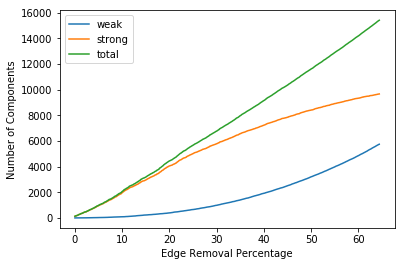

In [10]:
start = time.time()
res_test("complete_networld_cap.edgelist", runs=1, redistribute=False, sort=False, extra_walks=False)
end = time.time() - start
print(end)

In [11]:
g = nx.read_edgelist("complete_networld_cap.edgelist", create_using = nx.DiGraph())

In [12]:
res_test(g, runs=1, redistribute=False, sort=False, extra_walks=False)

Run:  1


AttributeError: 'str' object has no attribute 'decode'